In [2]:
import numpy as np
import cv2
import json
import os
import yaml
import torch
import pdb
import open3d as o3d
import matplotlib.pyplot as plt
%matplotlib inline

## For single image

In [3]:
calib_folder = './calibration'
global_config = os.path.join(calib_folder, 'defaults.yaml')
camera_config = os.path.join(calib_folder, 'cameras.yaml')
with open(global_config) as f:
    global_config_dict = yaml.safe_load(f)

with open(camera_config) as f:
    camera_config_dict = yaml.safe_load(f)
    
def cart2hom(pts_3d: np.array) -> np.array:
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n,1))))
    return pts_3d_hom



In [331]:

TRAIN =['bytes-cafe-2019-02-07_0',
    'clark-center-2019-02-28_0',
    'clark-center-2019-02-28_1',
    'clark-center-intersection-2019-02-28_0',
    'cubberly-auditorium-2019-04-22_0',
    'forbes-cafe-2019-01-22_0',
    'gates-159-group-meeting-2019-04-03_0',
    'gates-ai-lab-2019-02-08_0',
    'gates-basement-elevators-2019-01-17_1',
    'gates-to-clark-2019-02-28_1',
    'hewlett-packard-intersection-2019-01-24_0',
    'huang-2-2019-01-25_0',
    'huang-basement-2019-01-25_0',
    'huang-lane-2019-02-12_0',
    'jordan-hall-2019-04-22_0',
    'memorial-court-2019-03-16_0',
    'meyer-green-2019-03-16_0',
    'nvidia-aud-2019-04-18_0',
    'packard-poster-session-2019-03-20_0',
    'packard-poster-session-2019-03-20_1',
    'packard-poster-session-2019-03-20_2',
    'stlc-111-2019-04-19_0',
    'svl-meeting-gates-2-2019-04-08_0',
    'svl-meeting-gates-2-2019-04-08_1',
    'tressider-2019-03-16_0',
    'tressider-2019-03-16_1',
    'tressider-2019-04-26_2']


In [369]:
sensor = "sensor_0"
lidar = "upper"
translation = {
    "sensor_8": {"upper2indi":{"T": torch.tensor([0,0,-0.17]), "theta": 0.417*np.pi},
                 "lower2indi":{"T": torch.tensor([0,0,0.27]), "theta": 0.3945*np.pi}},
    
    "sensor_6": {"upper2indi":{"T": torch.tensor([0,0,-0.10]), "theta": 0.840*np.pi},
                 "lower2indi":{"T": torch.tensor([0,0,0.3]), "theta": 0.815*np.pi}},
    
    "sensor_4": {"upper2indi":{"T": torch.tensor([0,0,-0.15]), "theta": 1.235*np.pi},
                 "lower2indi":{"T": torch.tensor([0,0,0.32]), "theta": 1.207*np.pi}},
    
    "sensor_2": {"upper2indi":{"T": torch.tensor([0,0,-0.31]), "theta": 1.622*np.pi},
                 "lower2indi":{"T": torch.tensor([0,0,0.18]), "theta": 1.598*np.pi}},
    
    "sensor_0": {"upper2indi":{"T": torch.tensor([0,0,-0.25]), "theta": 0.028*np.pi},
                 "lower2indi":{"T": torch.tensor([0,0,0.18]), "theta": 0.005*np.pi}},
}

In [370]:

h, w = 480,752
K = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['K'][:-1].split()]).reshape(3,3)
R = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['R'][:-1].split()]).reshape(3,3)
T = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['T'].split()]).reshape(3,1)/1000
D = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['D'].split()])


loc = 'clark-center-2019-02-28_1'
data_root = "/home/tho/datasets/JRDB2022/train_dataset_with_activity"
if not os.path.isdir(data_root) and loc != "bytes-cafe-2019-02-07_0":
    print("please download JRDB22 data and specify the data_root")
    print("using default config")
    data_root = "."
    loc = "bytes-cafe-2019-02-07_0"

pcd = o3d.io.read_point_cloud(f"{data_root}/pointclouds/{lidar}_velodyne/{loc}/000000.pcd")
image = cv2.imread(f"{data_root}/images/image_{sensor[-1]}/{loc}/000000.jpg")

points_3d = np.array(pcd.points)
points = torch.from_numpy(points_3d)

# Velodyne to reference coordinate
points[:, :3] = points[:, :3] - translation[sensor][f'{lidar}2indi']['T'] 
theta = translation[sensor][f'{lidar}2indi']['theta'] # needs further calibration
rotation_matrix = torch.Tensor([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]).type(
    points.type())
points[:, :2] = torch.matmul(rotation_matrix, points[:, :2].unsqueeze(2)).squeeze()

# move to camera world coordinates
points = points[:, [1, 2, 0]]
points[:, 0] *= -1
points[:, 1] *= -1


In [371]:
hom_points = cart2hom(points)

RT = np.vstack([np.hstack((R,T)), [0,0,0,1]])

pts_ref = np.dot(RT, np.transpose(hom_points))
pts_ref = np.transpose(pts_ref)
pts_ref = pts_ref[pts_ref[:,2]>0]

In [372]:
# Normalize
x, y = pts_ref[:,0]/pts_ref[:,2], pts_ref[:,1]/pts_ref[:,2]

# Calculate radial distortion
k1,k2,k3,k4,k5 = D
k6 = 0

r2 = x**2 + y**2
r4 = r2**2
r6 = r2 * r4
rad_dist = (1 + k1*r2 + k2*r4 + k3*r6) 
# Get intrinsics params
fx, _, cx = K[0]
_, fy, cy = K[1]
# Apply radial distortion and intrinsic parameters
xd = fx * x * rad_dist + cx
yd = fy * y * rad_dist + cy
# Get the 2D points
pts_2d = np.stack([xd,yd]).transpose()

In [373]:
# # # for 3D visualisation
pc = o3d.geometry.PointCloud()
# pc.points = o3d.utility.Vector3dVector(pts_ref[:,:3])
# mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
#     size=0.6, origin=[0,0,0])
# o3d.visualization.draw_geometries([pc,mesh_frame],
# 								  front = [ -0.13356920137754022, -0.12570405283335623, -0.98303497371387305 ],
# 								  lookat = [ 4.0407917616177658, 2.9981258510217126, 26.421208779194139 ],
# 								  up = [ -0.016840113915896158, -0.99149201237214801, 0.12907362226856409 ],
# 								  zoom = 0.29999999999999993)

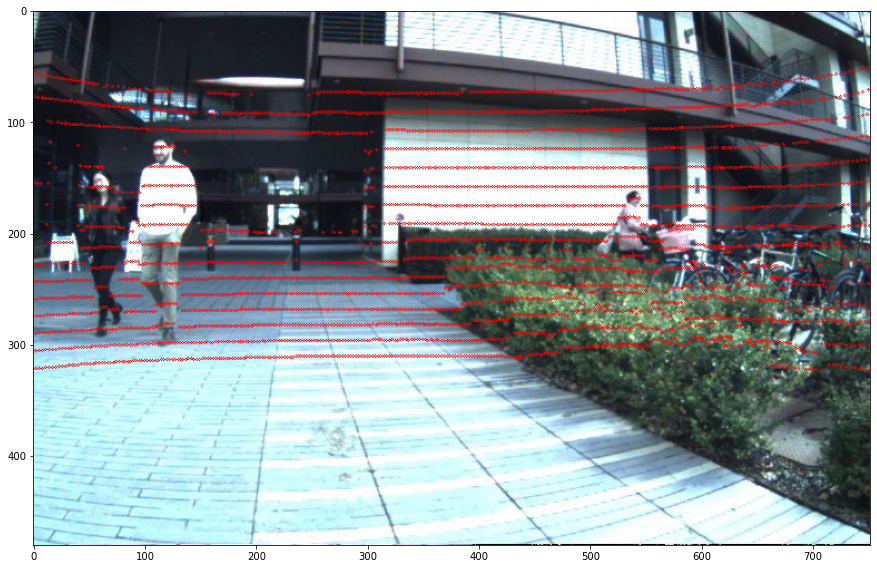

In [374]:
# Visualize
plt.figure(figsize=(15, 10))
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
for pts in pts_2d:
    if (0<pts[0]<1000) and (0<pts[1]<1000):
        cv2.circle(hsv_image, (int(pts[0]), int(pts[1])), 1, (0, 255, 255), 1)
hsv_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
plt.imshow(hsv_image)

## convert to single RT matrix

In [12]:
import numpy as np
import cv2
import json
import os
import yaml
import torch
import pdb
import open3d as o3d
import matplotlib.pyplot as plt
%matplotlib inline

calib_folder = './calibration'
global_config = os.path.join(calib_folder, 'defaults.yaml')
camera_config = os.path.join(calib_folder, 'cameras.yaml')
with open(global_config) as f:
    global_config_dict = yaml.safe_load(f)

with open(camera_config) as f:
    camera_config_dict = yaml.safe_load(f)
    
def cart2hom(pts_3d: np.array) -> np.array:
    n = pts_3d.shape[0]
    pts_3d_hom = np.hstack((pts_3d, np.ones((n,1))))
    return pts_3d_hom

In [155]:
h, w = 480,752
K = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['K'][:-1].split()]).reshape(3,3)
R = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['R'][:-1].split()]).reshape(3,3)
T = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['T'].split()]).reshape(3,1)/1000
D = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['D'].split()])

sensor_8
new R
[[ 0.93220272 -0.36192463  0.00296577]
 [ 0.00877939  0.01441963 -0.999857  ]
 [ 0.36183099  0.93209597  0.0166195 ]]
new T
[ 0.00390145 -0.29935669 -0.04241558]
sensor_8
new R
[[ 0.95543646 -0.29518217  0.00296577]
 [ 0.00773905  0.01500368 -0.999857  ]
 [ 0.29509629  0.95532336  0.0166195 ]]
new T
[ 0.00259651  0.1405804  -0.04972817]
sensor_6
new R
[[ 0.68504945  0.7284129   0.0110391 ]
 [ 0.01088345  0.00491841 -0.999929  ]
 [-0.72841569  0.68512095 -0.00455829]]
new T
[ 0.00284916 -0.2272069  -0.05222803]
sensor_6
new R
[[ 0.62578705  0.77991581  0.0110391 ]
 [ 0.010464    0.00575716 -0.999929  ]
 [-0.7799242   0.62585811 -0.00455829]]
new T
[-0.00156648  0.17276471 -0.05040471]
sensor_4
new R
[[-0.49430764  0.86928502 -0.00160497]
 [-0.004683   -0.0045092  -0.999979  ]
 [-0.86927452 -0.49429016  0.00629979]]
new T
[-0.0005746  -0.1551266  -0.05511233]
sensor_4
new R
[[-0.56876419  0.82249851 -0.00160497]
 [-0.00426875 -0.00490317 -0.999979  ]
 [-0.82248958 -0.56874

/tmp/ipykernel_401872/3205109574.py:85: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 10))


sensor_8
new R
[[ 0.93220272 -0.36192463  0.00296577]
 [ 0.00877939  0.01441963 -0.999857  ]
 [ 0.36183099  0.93209597  0.0166195 ]]
new T
[ 0.00390145 -0.29935669 -0.04241558]
sensor_8
new R
[[ 0.95543646 -0.29518217  0.00296577]
 [ 0.00773905  0.01500368 -0.999857  ]
 [ 0.29509629  0.95532336  0.0166195 ]]
new T
[ 0.00259651  0.1405804  -0.04972817]
sensor_6
new R
[[ 0.68504945  0.7284129   0.0110391 ]
 [ 0.01088345  0.00491841 -0.999929  ]
 [-0.72841569  0.68512095 -0.00455829]]
new T
[ 0.00284916 -0.2272069  -0.05222803]
sensor_6
new R
[[ 0.62578705  0.77991581  0.0110391 ]
 [ 0.010464    0.00575716 -0.999929  ]
 [-0.7799242   0.62585811 -0.00455829]]
new T
[-0.00156648  0.17276471 -0.05040471]
sensor_4
new R
[[-0.49430764  0.86928502 -0.00160497]
 [-0.004683   -0.0045092  -0.999979  ]
 [-0.86927452 -0.49429016  0.00629979]]
new T
[-0.0005746  -0.1551266  -0.05511233]
sensor_4
new R
[[-0.56876419  0.82249851 -0.00160497]
 [-0.00426875 -0.00490317 -0.999979  ]
 [-0.82248958 -0.56874

sensor_8
new R
[[ 0.93220272 -0.36192463  0.00296577]
 [ 0.00877939  0.01441963 -0.999857  ]
 [ 0.36183099  0.93209597  0.0166195 ]]
new T
[ 0.00390145 -0.29935669 -0.04241558]
sensor_8
new R
[[ 0.95543646 -0.29518217  0.00296577]
 [ 0.00773905  0.01500368 -0.999857  ]
 [ 0.29509629  0.95532336  0.0166195 ]]
new T
[ 0.00259651  0.1405804  -0.04972817]
sensor_6
new R
[[ 0.68504945  0.7284129   0.0110391 ]
 [ 0.01088345  0.00491841 -0.999929  ]
 [-0.72841569  0.68512095 -0.00455829]]
new T
[ 0.00284916 -0.2272069  -0.05222803]
sensor_6
new R
[[ 0.62578705  0.77991581  0.0110391 ]
 [ 0.010464    0.00575716 -0.999929  ]
 [-0.7799242   0.62585811 -0.00455829]]
new T
[-0.00156648  0.17276471 -0.05040471]
sensor_4
new R
[[-0.49430764  0.86928502 -0.00160497]
 [-0.004683   -0.0045092  -0.999979  ]
 [-0.86927452 -0.49429016  0.00629979]]
new T
[-0.0005746  -0.1551266  -0.05511233]
sensor_4
new R
[[-0.56876419  0.82249851 -0.00160497]
 [-0.00426875 -0.00490317 -0.999979  ]
 [-0.82248958 -0.56874

sensor_8
new R
[[ 0.93220272 -0.36192463  0.00296577]
 [ 0.00877939  0.01441963 -0.999857  ]
 [ 0.36183099  0.93209597  0.0166195 ]]
new T
[ 0.00390145 -0.29935669 -0.04241558]
sensor_8
new R
[[ 0.95543646 -0.29518217  0.00296577]
 [ 0.00773905  0.01500368 -0.999857  ]
 [ 0.29509629  0.95532336  0.0166195 ]]
new T
[ 0.00259651  0.1405804  -0.04972817]
sensor_6
new R
[[ 0.68504945  0.7284129   0.0110391 ]
 [ 0.01088345  0.00491841 -0.999929  ]
 [-0.72841569  0.68512095 -0.00455829]]
new T
[ 0.00284916 -0.2272069  -0.05222803]
sensor_6
new R
[[ 0.62578705  0.77991581  0.0110391 ]
 [ 0.010464    0.00575716 -0.999929  ]
 [-0.7799242   0.62585811 -0.00455829]]
new T
[-0.00156648  0.17276471 -0.05040471]
sensor_4
new R
[[-0.49430764  0.86928502 -0.00160497]
 [-0.004683   -0.0045092  -0.999979  ]
 [-0.86927452 -0.49429016  0.00629979]]
new T
[-0.0005746  -0.1551266  -0.05511233]
sensor_4
new R
[[-0.56876419  0.82249851 -0.00160497]
 [-0.00426875 -0.00490317 -0.999979  ]
 [-0.82248958 -0.56874

sensor_2
new R
[[-0.94787183 -0.31835989 -0.0136361 ]
 [ 0.01168756  0.00802983 -0.999899  ]
 [ 0.31843826 -0.94793558 -0.00389039]]
new T
[ 0.00219697  0.17343205 -0.04703083]
sensor_0
new R
[[-8.44608965e-02 -9.96426584e-01 -6.54539000e-04]
 [ 5.07070147e-05  6.52587486e-04 -1.00000000e+00]
 [ 9.96426584e-01 -8.44608965e-02 -4.59231000e-06]]
new T
[-1.74058950e-04 -2.53709740e-01 -5.69188481e-02]
sensor_0
new R
[[-1.23047129e-02 -9.99924084e-01 -6.54539000e-04]
 [ 3.46194894e-06  6.54545372e-04 -1.00000000e+00]
 [ 9.99924084e-01 -1.23047129e-02 -4.59231000e-06]]
new T
[ 1.07392825e-04  1.76290267e-01 -5.69168734e-02]
sensor_8
new R
[[ 0.93220272 -0.36192463  0.00296577]
 [ 0.00877939  0.01441963 -0.999857  ]
 [ 0.36183099  0.93209597  0.0166195 ]]
new T
[ 0.00390145 -0.29935669 -0.04241558]
sensor_8
new R
[[ 0.95543646 -0.29518217  0.00296577]
 [ 0.00773905  0.01500368 -0.999857  ]
 [ 0.29509629  0.95532336  0.0166195 ]]
new T
[ 0.00259651  0.1405804  -0.04972817]
sensor_6
new R
[[ 0

sensor_6
new R
[[ 0.68504945  0.7284129   0.0110391 ]
 [ 0.01088345  0.00491841 -0.999929  ]
 [-0.72841569  0.68512095 -0.00455829]]
new T
[ 0.00284916 -0.2272069  -0.05222803]
sensor_6
new R
[[ 0.62578705  0.77991581  0.0110391 ]
 [ 0.010464    0.00575716 -0.999929  ]
 [-0.7799242   0.62585811 -0.00455829]]
new T
[-0.00156648  0.17276471 -0.05040471]
sensor_4
new R
[[-0.49430764  0.86928502 -0.00160497]
 [-0.004683   -0.0045092  -0.999979  ]
 [-0.86927452 -0.49429016  0.00629979]]
new T
[-0.0005746  -0.1551266  -0.05511233]
sensor_4
new R
[[-0.56876419  0.82249851 -0.00160497]
 [-0.00426875 -0.00490317 -0.999979  ]
 [-0.82248958 -0.56874585  0.00629979]]
new T
[ 1.79733389e-04  3.14863533e-01 -5.80732328e-02]
sensor_2
new R
[[-0.96915987 -0.24605525 -0.0136361 ]
 [ 0.01225921  0.00712663 -0.999899  ]
 [ 0.24612859 -0.96922934 -0.00389039]]
new T
[-0.00448472 -0.31651847 -0.04893712]
sensor_2
new R
[[-0.94787183 -0.31835989 -0.0136361 ]
 [ 0.01168756  0.00802983 -0.999899  ]
 [ 0.31843

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

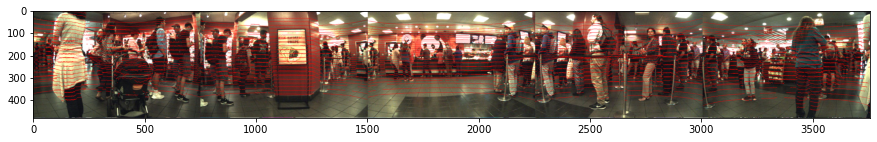

In [375]:
# loc = 'bytes-cafe-2019-02-07_0'
data_root = "/home/tho/datasets/JRDB2022/train_dataset_with_activity"
# plt.figure()

images = {
    "sensor_8": None,
    "sensor_6": None,
    "sensor_4": None,
    "sensor_2": None,
    "sensor_0": None,
}

#subplot(r,c) provide the no. of rows and columns
# fig = plt.figure(figsize=(15, 15))
for loc in TRAIN:
    for idx, (sensor, v) in enumerate(translation.items()):
        all_pts_2d = None
        K = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['K'][:-1].split()]).reshape(3,3)
        R = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['R'][:-1].split()]).reshape(3,3)
        T = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['T'].split()]).reshape(3,1)/1000
        D = np.array([np.float64(x) for x in camera_config_dict['cameras'][sensor]['D'].split()])

        for lidar in ['upper','lower']:

            lidar2indi = v[f'{lidar}2indi']
            trans = -lidar2indi['T'].reshape([3,1])
            t = lidar2indi['theta']
            rots = np.zeros([4,4])
            c = np.cos(t)
            s = np.sin(t)
            rots = [[c,-s, 0],
                    [s, c, 0],
                    [0, 0, 1]]
            rots = np.vstack([np.hstack([rots, trans]),[0,0,0,1]])
            swap = np.array([[0 ,-1, 0, 0],
                             [0 , 0,-1, 0],
                             [1 , 0, 0, 0],
                             [0 , 0, 0, 1]])

            RT = np.vstack([np.hstack((R,T)), [0,0,0,1]])
            lidarnewRT = RT.dot(swap).dot(rots)
            print(sensor)
            print("new R")
            print(lidarnewRT[:3,:3])
            print("new T")
            print(lidarnewRT[:3,3])


            pcd = o3d.io.read_point_cloud(f"{data_root}/pointclouds/{lidar}_velodyne/{loc}/000000.pcd")
            image = cv2.imread(f"{data_root}/images/image_{sensor[-1]}/{loc}/000000.jpg")

            points_3d = np.array(pcd.points)
            hom_points = cart2hom(points_3d)

            pts_ref = np.dot(lidarnewRT, np.transpose(hom_points))
            pts_ref = np.transpose(pts_ref)
            pts_ref = pts_ref[pts_ref[:,2]>0]

            # Normalize
            x, y = pts_ref[:,0]/pts_ref[:,2], pts_ref[:,1]/pts_ref[:,2]

            # Calculate radial distortion
            k1,k2,k3,k4,k5 = D
            k6 = 0

            r2 = x**2 + y**2
            r4 = r2**2
            r6 = r2 * r4
            rad_dist = (1 + k1*r2 + k2*r4 + k3*r6) 
            # Get intrinsics params
            fx, _, cx = K[0]
            _, fy, cy = K[1]
            # Apply radial distortion and intrinsic parameters
            xd = fx * x * rad_dist + cx
            yd = fy * y * rad_dist + cy
            # Get the 2D points
            pts_2d = np.stack([xd,yd]).transpose()

            if all_pts_2d is not None:
                all_pts_2d = np.vstack([all_pts_2d, pts_2d])
            else:
                all_pts_2d = pts_2d

        # Visualize
        plt.figure(figsize=(15, 10))
        hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        for pts in all_pts_2d:
            if (0<pts[0]<1000) and (0<pts[1]<1000):
                cv2.circle(hsv_image, (int(pts[0]), int(pts[1])), 1, (0, 255, 255), 1)
        hsv_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)


        images[sensor] = hsv_image

    final_image = cv2.hconcat([images['sensor_6'], images['sensor_8'],
                               images['sensor_0'], images['sensor_2'],
                               images['sensor_4']])

    cv2.imwrite(f"{loc}_projected.png", final_image)
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))

    